<a href="https://colab.research.google.com/github/andresvc21/Random_Practice_ML/blob/main/Homework_M5_Autoencoder_Andres_Villegas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##INTRO




### Directives
* Create the autoencoders described below, you can play with the topology, those are just starting points
* Use GPU runtime
* Print 10 inputs and their associated outputs
* Don't forget to normalize your data
* Use the Functional API for Keras

### Autoencoders to build
1. Stacked 784 - 392 - 196 - 392 - 784 (tied weights)
2. Convolutional Encoder (conv, maxpool, conv, maxpool, conv, maxpool). Decoder (conv, upsample2d, conv, upsample2d, conv, upsample2d, conv)


In [ ]:
# Choose Python 3 runtime
!pip install --upgrade tensorflow

     |████████████████████████████████| 462 kB 6.9 MB/s 


In [ ]:
#Required libraries

from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

(X_train, _), (X_test, _) = mnist.load_data()
all_data = np.concatenate((X_train, X_test))
all_data.shape

11501568/11490434 [==============================] - 0s 0us/step


(70000, 28, 28)

#Explore Data


In [ ]:
def print_first_9(data):
  fig = plt.figure()
  for i in range(9):
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    plt.imshow(data[i], interpolation='none')
    plt.title("Digit: {}".format(i))
    plt.xticks([])
    plt.yticks([])

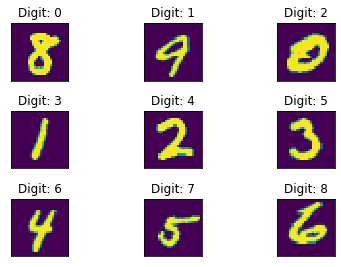

In [ ]:
print_first_9(all_data[-9:])

#Normalize


In [ ]:
max_value = float(X_train.max())
X_Train = X_train.astype(np.float32) / max_value
X_Test = X_test.astype(np.float32) / max_value

In [ ]:
#We need a validation split
print(X_Train.shape)

X_train, X_valid = X_Train[:-10000], X_Train[-10000:]
X_train.shape, X_valid.shape

(60000, 28, 28)


((50000, 28, 28), (10000, 28, 28))

#Function Display


In [ ]:
#Displays the original images and their reconstructions
def plot_image(image):
  plt.imshow(image, cmap="binary")
  plt.axis("off")

def show_reconstructions(model, images=X_valid, n_images=9):
  reconstructions = model.predict(images[:n_images])
  fig = plt.figure(figsize=(n_images * 1.5, 3))
  for image_index in range(n_images):
     plt.subplot(2, n_images, 1 + image_index)
     plot_image(images[image_index])
     plt.subplot(2, n_images, 1 + n_images + image_index)
     plot_image(reconstructions[image_index])

#Architecture

In [ ]:
#Encoder
inputs = keras.Input(shape=(28,28))
lr_flatten = keras.layers.Flatten()(inputs)
lr1 = keras.layers.Dense(392, activation="selu")(lr_flatten)
lr2 = keras.layers.Dense(196, activation="selu")(lr1)

#Decoder
lr3 =  keras.layers.Dense(392, activation="selu")(lr2)
lr4 =  keras.layers.Dense(28 * 28, activation="sigmoid")(lr3)
outputs = keras.layers.Reshape([28, 28])(lr4)
stacked_ae = keras.models.Model(inputs,outputs)
stacked_ae.compile(loss="binary_crossentropy",optimizer=keras.optimizers.SGD(lr=1.5))
stacked_ae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 392)               307720    
                                                                 
 dense_1 (Dense)             (None, 196)               77028     
                                                                 
 dense_2 (Dense)             (None, 392)               77224     
                                                                 
 dense_3 (Dense)             (None, 784)               308112    
                                                                 
 reshape (Reshape)           (None, 28, 28)            0     

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


#Fit and Training


In [ ]:
h_stack = stacked_ae.fit(X_train, X_train, epochs=20,validation_data=[X_valid, X_valid])

Epoch 1/20
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0677 - val_loss: 0.0684
Epoch 2/20
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0676 - val_loss: 0.0684
Epoch 3/20
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0674 - val_loss: 0.0680
Epoch 4/20
1563/1563 [==============================] - 4s 3ms/step - loss: 0.0673 - val_loss: 0.0679
Epoch 5/20
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0672 - val_loss: 0.0679
Epoch 6/20
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0671 - val_loss: 0.0679
Epoch 7/20
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0670 - val_loss: 0.0677
Epoch 8/20
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0669 - val_loss: 0.0675
Epoch 9/20
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0668 - val_loss: 0.0676
Epoch 10/20
1563/1563 [==============================] - 5s 3ms/step - loss: 0.066

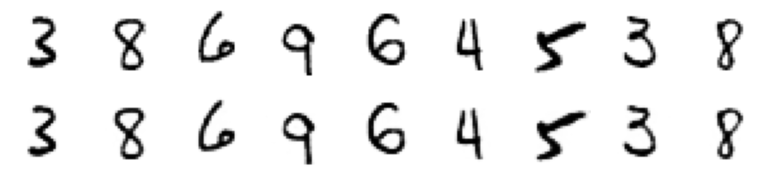

In [ ]:
show_reconstructions(stacked_ae)

#Now Tying Weights


In [ ]:
#Custom lyer to tie weights

import tensorflow 

class DenseTranspose(keras.layers.Layer):
  def __init__(self, dense, activation=None, **kwargs):
      self.dense = dense
      self.activation = keras.activations.get(activation)
      super().__init__(**kwargs)
  def build(self, batch_input_shape):
      self.biases = self.add_weight(name="bias",    initializer="zeros",shape=[self.dense.input_shape[-1]])
      super().build(batch_input_shape)
  def call(self, inputs):
      z = tensorflow.matmul(inputs, self.dense.weights[0], transpose_b=True)
      return self.activation(z + self.biases)

dense_1 = keras.layers.Dense(392, activation="selu")
dense_2 = keras.layers.Dense(196, activation="selu")

#tied_encoder
inputs = keras.Input(shape=(28,28))
l_flatten = keras.layers.Flatten()(inputs)
l_en1 = dense_1(l_flatten)
l_en2 = dense_2(l_en1)

#tied_decoder
l_dc1 = DenseTranspose(dense_2, activation="selu")(l_en2)
l_dc2 = DenseTranspose(dense_1, activation="sigmoid")(l_dc1)
outputs = keras.layers.Reshape([28, 28])(l_dc2)
tied_ae = keras.models.Model(inputs, outputs)
tied_ae.compile(loss="binary_crossentropy",optimizer=keras.optimizers.SGD(lr=1.5))
tied_ae.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_8 (Dense)             (None, 392)               307720    
                                                                 
 dense_9 (Dense)             (None, 196)               77028     
                                                                 
 dense_transpose_2 (DenseTra  (None, 392)              77420     
 nspose)                                                         
                                                                 
 dense_transpose_3 (DenseTra  (None, 784)              308504    
 nspose)                                                   

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
#fit the model 
h_tied = tied_ae.fit(X_train, X_train, epochs=20,validation_data=[X_valid, X_valid])

Epoch 1/20
1563/1563 [==============================] - 7s 4ms/step - loss: 0.1096 - val_loss: 0.0826
Epoch 2/20
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0782 - val_loss: 0.0778
Epoch 3/20
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0741 - val_loss: 0.0732
Epoch 4/20
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0720 - val_loss: 0.0722
Epoch 5/20
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0708 - val_loss: 0.0708
Epoch 6/20
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0699 - val_loss: 0.0703
Epoch 7/20
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0693 - val_loss: 0.0712
Epoch 8/20
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0688 - val_loss: 0.0703
Epoch 9/20
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0684 - val_loss: 0.0693
Epoch 10/20
1563/1563 [==============================] - 5s 3ms/step - loss: 0.068

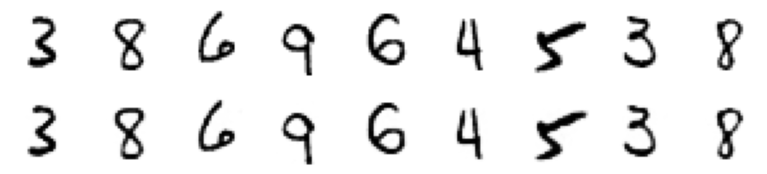

In [ ]:
# reconstruct the image
show_reconstructions(tied_ae)

Conclusion: the output images are very much similar to the input images 

Source



*   Deep Learning Courses
*   https://medium.com/@sahoo.puspanjali58/a-beginners-guide-to-build-stacked-autoencoder-and-tying-weights-with-it-9daee61eab2b

